In [1]:
import numpy as np
import pandas as pd
import sys

sys.path.insert(1, '../../../scripts/')
from s3_support import *
%matplotlib inline

# Load data

In [2]:
# load data
q = '''select
            form,
            date_trunc('month', date) as month,
            count(id) as count,
            sum(amount) as volume
        from transactions
            where status='A'
            group by form, date_trunc('month', date)'''
df = redshift_query_read(q)

In [4]:
df['month'] = pd.to_datetime(df['month'])
df.sort_values('month', ascending=True, inplace=True)

# Compute means and standard deviations

In [6]:
meta_data = []
form_data = []

for form in df['form'].unique():
    _df = df[df['form']==form].copy()
    _df.sort_values('month', ascending=True, inplace=True)
    _df = _df[_df['volume']>0]
    
    meta_data.append({
        "form": form,
        "len": len(_df)
    })
    
    _df['cat_month'] = _df['month'].dt.month
    _df['count_growth'] = _df['count'].diff() / _df['count'].shift()
    _df['volume_growth'] = _df['volume'].diff() / _df['volume'].shift()
    
    grpd = _df.groupby('cat_month')[['count_growth', 'volume_growth']].agg(['std', 'mean'])
    grpd['form'] = form
    
    form_data.append(grpd)

In [7]:
df_meta = pd.DataFrame(meta_data)

for i in [0, 3, 6, 12, 24, 36]:
    seg_len = len(df_meta[df_meta['len']>i])
    seg_perc = (float(seg_len) / float(len(df_meta))) * 100.
    
    print("Forms with greater than {} entries: {} ({:.2f}%)".format(i, seg_len, seg_perc))

Forms with greater than 0 entries: 21177 (96.66%)
Forms with greater than 3 entries: 10020 (45.74%)
Forms with greater than 6 entries: 6571 (29.99%)
Forms with greater than 12 entries: 4469 (20.40%)
Forms with greater than 24 entries: 2629 (12.00%)
Forms with greater than 36 entries: 1742 (7.95%)


# Testing

## Simple mean projection

In [13]:
test_forms = df_meta[df_meta['len']>24]['form'].tolist()

In [14]:
test_form_data = []
train_form_data = []

for form in test_forms:
    # isolate this org's data
    _df = df[df['form']==form].copy()
    _df.sort_values('month', ascending=True, inplace=True)
    _df = _df[_df['volume']>0]
    
    # compute month over month growth
    _df['cat_month'] = _df['month'].dt.month
    _df['count_growth'] = _df['count'].diff() / _df['count'].shift()
    _df['volume_growth'] = _df['volume'].diff() / _df['volume'].shift()
    
    # train/test split at 12 months
    test_form_data.append(_df.iloc[12:])
    _df = _df.head(24)
    
    # mean & std of monthly growth
    grpd = _df.groupby('cat_month')[['count_growth', 'volume_growth']].agg(['std', 'mean'])
    grpd['form'] = form
    
    train_form_data.append(grpd)

In [15]:
print("mean test entry per form: {:.0f}".format(np.mean([len(e) for e in test_form_data])))

mean test entry per form: 42


In [18]:
test_results = []
len_error = 0
for form in test_forms:
    # get parameters and test data
    params = [e for e in train_form_data if e['form'].iloc[0]==form][0]
    test_data = [e for e in test_form_data if e['form'].iloc[0]==form][0]
    
    # iterate through test data and compute percentage errors
    try:
        test_data['projected_vol_growth'] = test_data['cat_month'].apply(lambda x: params['volume_growth']['mean'][x])
        test_data['projection_error'] = (test_data['volume_growth'] - test_data['projected_vol_growth']) * 100.

        test_results.append({
            'form': form,
            'test_samples': len(test_data),
            'mae': test_data['projection_error'].abs().mean(),
            'mse': test_data['projection_error'].pow(2).mean()
        })
    except:
        len_error = len_error + 1

In [19]:
print("{} test results; {} errors".format(len(test_results), len_error))

2448 test results; 181 errors


In [20]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)

df_test_results = pd.DataFrame(test_results)
df_test_results[['mae', 'mse', 'test_samples']].mean()

mae                  2689.0566
mse            5276954420.5675
test_samples           41.9473
dtype: float64

AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


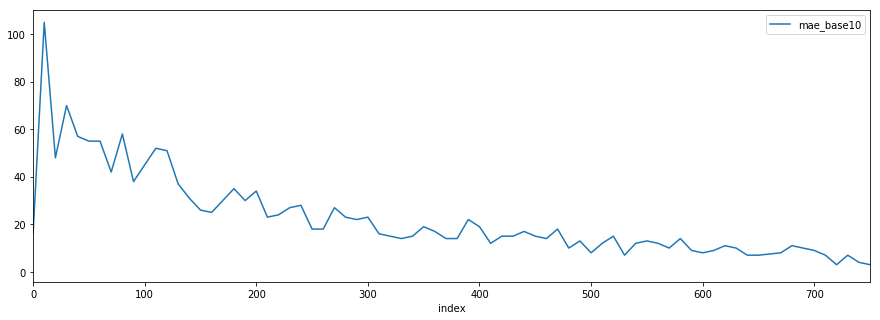

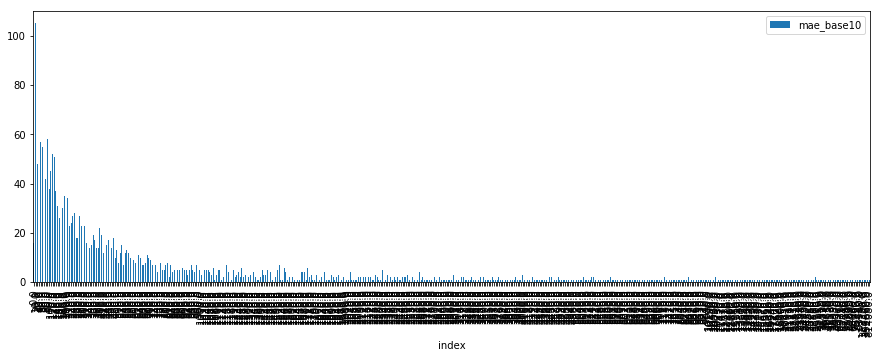

In [21]:
df_test_results['mae_base10'] = df_test_results['mae'].round(-1)
print(df_test_results['mae_base10'].value_counts().reset_index().sort_values("index").plot(x="index", figsize=(15,5), xlim=(0,750)))
print(df_test_results['mae_base10'].value_counts().reset_index().sort_values("index").plot(x="index", kind="bar", figsize=(15,5), xlim=(0,750)))

In [22]:
error_rates = [15., 25., 50., 100., 250., 500., 1000., 2500.]
len_test_results = float(len(df_test_results))

for er in error_rates:
    len_this_error_rate = float(len(df_test_results[df_test_results['mae']<er]))
    mean_test_samples = df_test_results[df_test_results['mae']<er]['test_samples'].mean()
    print("< {}% error: {} form ({:.2f}%; {:.2f} samples)".format(int(er), int(len_this_error_rate), (len_this_error_rate / len_test_results) * 100., mean_test_samples))

< 15% error: 121 form (4.94%; 22.60 samples)
< 25% error: 169 form (6.90%; 25.02 samples)
< 50% error: 325 form (13.28%; 29.91 samples)
< 100% error: 563 form (23.00%; 34.34 samples)
< 250% error: 1053 form (43.01%; 37.97 samples)
< 500% error: 1471 form (60.09%; 39.93 samples)
< 1000% error: 1823 form (74.47%; 41.08 samples)
< 2500% error: 2136 form (87.25%; 41.69 samples)
